In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ventilation_wall
import envelope_performance_factors
import global_number

# 通気層を有する壁体の計算テスト
## パラメータを設定
    theta_e: 外気温度[degree C]
    theta_r: 室内温度[degree C]
    J_surf: 外気側表面に入射する日射量[W/m2]
    a_surf: 外気側表面日射吸収率[-]
    C_1: 外気側部材の熱コンダクタンス[W/(m2・K)]
    C_2: 室内側部材の熱コンダクタンス[W/(m2・K)]
    l_h: 通気層の長さ[m]
    l_w: 通気層の幅[m]
    l_d: 通気層の厚さ[m]
    angle: 通気層の傾斜角[°]
    v_a: 通気層の平均風速[m/s]
    l_s: 通気胴縁または垂木の間隔[m]
    emissivity_1: 通気層に面する面1の放射率[-]
    emissivity_2: 通気層に面する面2の放射率[-]

### 定数を設定

In [2]:
h_out = global_number.get_h_out() # 室外側総合熱伝達率, W/(m2・K)
h_in = global_number.get_h_in() # 室内側総合熱伝達率, W/(m2・K)

### 外気温度を設定

In [3]:
theta_e_array = [x for x in range(-20,40)]

### パラメータのリストを作成

In [4]:
parms = [ventilation_wall.Parameters(
    theta_e = theta_e,
    theta_r = 25,
    J_surf = 500,
    a_surf = 0.9,
    C_1 = 10,
    C_2 = 0.5,
    l_h = 6.0,
    l_w = 0.45,
    l_d = 0.018,
    angle = 90,
    v_a = 0.2,
    l_s = 0.45,
    emissivity_1 = 0.9,
    emissivity_2=0.9
) for theta_e in theta_e_array]

## 通気層の状態値を取得

In [5]:
# 各点の熱流、温度を格納する配列を用意
x1  = np.ndarray(len(parms))
status = []
q_surf_out = np.ndarray(len(parms))
q_surf_1 = np.ndarray(len(parms))
q_surf_2 = np.ndarray(len(parms))
q_suef_in = np.ndarray(len(parms))
q_suf_vent = np.ndarray(len(parms))
temp_surf_out = np.ndarray(len(parms))
temp_surf_1 = np.ndarray(len(parms))
temp_surf_2 = np.ndarray(len(parms))
temp_suef_in = np.ndarray(len(parms))
temp_suf_vent = np.ndarray(len(parms))

for i, parm in enumerate(parms):
    
    x1[i] = parm.theta_e
    
    # 通気層の状態値を取得
    status_buf: ventilation_wall.WallStatusValues = ventilation_wall.get_wall_status_values(parm, h_out, h_in)
    status.append(status_buf)
    
    # 各層の熱収支を検算
    q = ventilation_wall.get_heat_balance(status_buf.matrix_temp,parm, h_out, h_in)
    q_surf_out[i] = q[0][0]
    q_surf_1[i] = q[1][0]
    q_surf_2[i] = q[2][0]
    q_suef_in[i] = q[3][0]
    q_suf_vent[i] = q[4][0]
    
    # 各層の温度を取得
    temp_surf_out[i] = status_buf.matrix_temp[0][0]
    temp_surf_1[i] = status_buf.matrix_temp[1][0]
    temp_surf_2[i] = status_buf.matrix_temp[2][0]
    temp_suef_in[i] = status_buf.matrix_temp[3][0]
    temp_suf_vent[i] = status_buf.matrix_temp[4][0]

C:\Users\satoh\anaconda3\lib\site-packages\scipy\optimize\nonlin.py:1001: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)


### 各層の熱収支の検算結果を確認

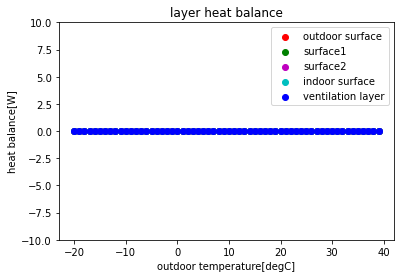

In [6]:
fig1 = plt.figure()
ax1 = fig1.subplots()

ax1.scatter(x1, q_surf_out, c="r", label="outdoor surface")
ax1.scatter(x1, q_surf_1, c="g", label="surface1")
ax1.scatter(x1, q_surf_2, c="m", label="surface2")
ax1.scatter(x1, q_suef_in, c="c", label="indoor surface")
ax1.scatter(x1, q_suf_vent, c="b", label="ventilation layer")

ax1.set_xlabel('outdoor temperature[degC]')
ax1.set_ylabel('heat balance[W]')

ax1.set_title("layer heat balance")

plt.ylim(-10, 10)
plt.legend()
plt.show()

### 各点の温度を確認

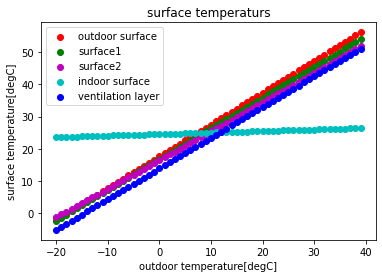

In [7]:
fig1 = plt.figure()
ax1 = fig1.subplots()

ax1.scatter(x1, temp_surf_out, c="r", label="outdoor surface")
ax1.scatter(x1, temp_surf_1, c="g", label="surface1")
ax1.scatter(x1, temp_surf_2, c="m", label="surface2")
ax1.scatter(x1, temp_suef_in, c="c", label="indoor surface")
ax1.scatter(x1, temp_suf_vent, c="b", label="ventilation layer")

ax1.set_xlabel('outdoor temperature[degC]')
ax1.set_ylabel('surface temperature[degC]')

ax1.set_title("surface temperaturs")

plt.legend()
plt.show()

## 通気層を有する壁体の熱貫流率,日射熱取得率の計算
### 熱貫流率(W/(m2・K)),日射熱取得率(-)を計算

In [8]:
u_e  = np.ndarray(len(parms))
eta_e  = np.ndarray(len(parms))

for i, parm in enumerate(parms):
    
    u_e[i] = envelope_performance_factors.overall_heat_transfer_coefficient(parms[i], status[i].matrix_temp[4][0], status[i].h_cv, status[i].h_rv)
    eta_e[i] = envelope_performance_factors.solar_heat_gain_coefficient(parms[i], status[i].matrix_temp[4][0], status[i].h_cv, status[i].h_rv)

C:\Users\satoh\Documents\sourcetree\03_ventilation_layer\envelope_performance_factors.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  u_e = u_s_dash * (theta_as_ave - parm.theta_r) / (theta_SAT - parm.theta_r)
C:\Users\satoh\Documents\sourcetree\03_ventilation_layer\envelope_performance_factors.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  eta_e = u_s_dash * parm.a_surf/h_out * (theta_as_ave - parm.theta_r) / (theta_SAT - parm.theta_r)


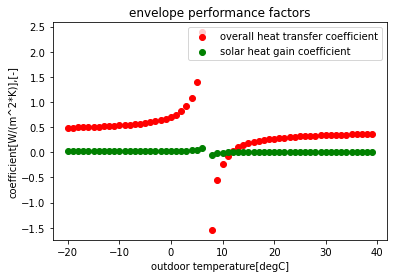

In [9]:
fig1 = plt.figure()
ax1 = fig1.subplots()

ax1.scatter(x1, u_e, c="r", label="overall heat transfer coefficient")
ax1.scatter(x1, eta_e, c="g", label="solar heat gain coefficient")

ax1.set_xlabel('outdoor temperature[degC]')
ax1.set_ylabel('coefficient[W/(m^2*K)],[-]')

ax1.set_title("envelope performance factors")

plt.legend()
plt.show()